# UMAP on the C.elegans dataset

In [2]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=3
import numpy as np
import pandas as pd
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umapns
from firelight.visualizers.colorization import get_distinct_colors
from matplotlib.colors import ListedColormap
import pickle
import matplotlib.lines as mlines
import matplotlib
from umapns.my_plot import plot_all_losses

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=3


In [3]:
dir_path = "../data/packer_c-elegans"
fig_path = "../figures"
seed = 0
special_cell_type = "Seam_cell"

In [4]:
# load the data
pca100 = pd.read_csv(os.path.join(dir_path,
                              "c-elegans_qc_final.txt"),
                     sep='\t',
                     header=None)
pca100.shape

(86024, 100)

In [5]:
# read meta data, obtain colors and ordering of cells that puts special_cell_type to the front and unlabelled cells to
# the back
meta = pd.read_csv(os.path.join(dir_path,
                              "c-elegans_qc_final_metadata.txt"),
                   sep=',',
                   header=0)

cell_types = meta["cell.type"].to_numpy().astype(str)

labels = np.zeros(len(cell_types)).astype(int)
name_to_label = {}
for i, phase in enumerate(np.unique(cell_types)):
    name_to_label[phase] = i
    labels[cell_types==phase] = i

special_cell_label = name_to_label[special_cell_type]
unnamed_label = name_to_label["nan"]

np.random.seed(seed)
colors = get_distinct_colors(len(name_to_label))
np.random.shuffle(colors)
colors[special_cell_label] = [0,0,0]
colors[unnamed_label] = [0.5, 0.5, 0.5]
cmap = ListedColormap(colors)

special_order1 = np.argsort(labels == special_cell_label, kind="stable") # put idx of special label to the back
special_order2 = np.argsort(labels[special_order1] != unnamed_label, kind="stable") # put idx of unnamed label to the front
special_order = special_order1[special_order2]
special_order_no_nan = special_order[(labels==unnamed_label).sum():]

## PCA

In [6]:
# load / compute and save 2D PCA
try:
    pca2 = np.load(os.path.join(dir_path, "PCA2D.np"))
except FileNotFoundError:
    pca_projector = PCA(n_components = 2)
    pca2 = pca_projector.fit_transform(np.array(pca100))
    np.save(os.path.join(dir_path, "PCA2D.npy"), pca2)

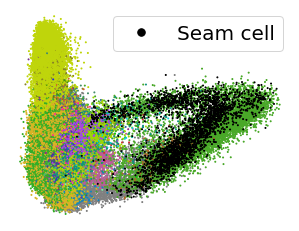

In [7]:
# plot PCA and save figure
plt.figure()
scatter = plt.scatter(*pca2[special_order].T,
                      c=colors[labels[special_order]],
                      s=1.0)
plt.axis("off")
plt.gca().set_aspect("equal")

# dummy black dot for legend with only one entry
black_dot = mlines.Line2D([], [], color='black', marker='.', linestyle="none",
                          markersize=15, label=" ".join(special_cell_type.split("_")))
plt.legend(handles=[black_dot], prop={'size': 20})

plt.savefig(os.path.join(fig_path, f"c_elegans_PCA2_seed_{seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)

## UMAP
We use the hyperparameter settings of Narayan et al.'s "Assessing single-cell transcriptomic variability through density-preserving data
visualization" paper (https://doi.org/10.1038/s41587-020-00801-7) in which they propose the method "Densmap"


### Log losses after full epoch

In [8]:
try:
    with open(os.path.join(dir_path, f"umapperns_after_seed_{seed}.pkl"), "rb") as file:
        umapperns_after = pickle.load(file)
        embd = umapperns_after.embedding_
except FileNotFoundError:
    umapperns_after = umapns.UMAP(metric="cosine",
                                  n_neighbors=30,
                                  n_epochs=750,
                                  log_losses="after",
                                  random_state=seed,
                                  verbose=True)
    embd_after = umapperns_after.fit_transform(pca100)
    with open(os.path.join(dir_path, f"umapperns_after_seed_{seed}.pkl"), "wb") as file:
        pickle.dump(umapperns_after, file, pickle.HIGHEST_PROTOCOL)


UMAP(angular_rp_forest=True, dens_frac=0.0, dens_lambda=0.0, log_losses='after',
     metric='cosine', n_epochs=750, n_neighbors=30, random_state=0,
     verbose=True)
Construct fuzzy simplicial set
Wed Apr 21 10:30:37 2021 Finding Nearest Neighbors
Wed Apr 21 10:30:37 2021 Building RP forest with 20 trees
Wed Apr 21 10:30:38 2021 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Wed Apr 21 10:31:03 2021 Finished Nearest Neighbor Search
Wed Apr 21 10:31:06 2021 Construct embedding
	completed  0  /  750 epochs
	completed  75  /  750 epochs
	completed  150  /  750 epochs
	completed  225  /  750 epochs
	completed  300  /  750 epochs
	completed  375  /  750 epochs
	completed  450  /  750 epochs
	completed  525  /  750 epochs
	completed  600  /  750 epochs
	completed  675  /  750 epochs
Wed Apr 21 11:11:50 2021 Finished embedding
Wed Apr 21 11:11:59 2021 Worst tree score: 0.71890403
Wed Apr 21 11:11:59 2021 Mean tree score: 0

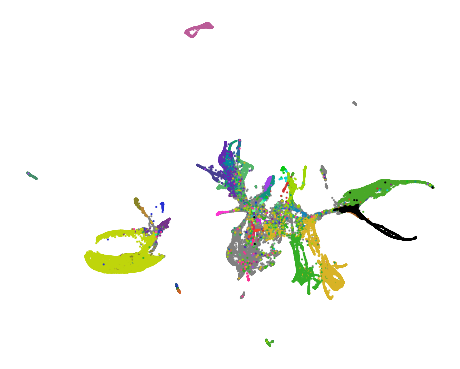

In [10]:
plt.figure(figsize=(8,8))
scatter = plt.scatter(-embd_after[special_order][:,1],
                      -embd_after[special_order][:,0],
                      c=labels[special_order],
                      s=1.0,
                      alpha=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")

plt.savefig(os.path.join(fig_path, f"c_elegans_after_seed_{seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)

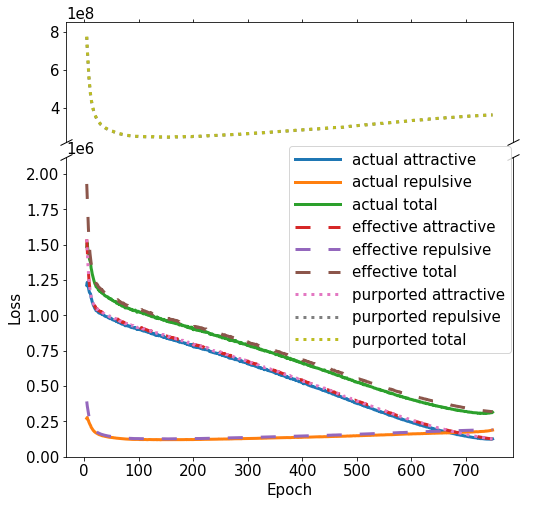

In [11]:
start=5 # omit early epochs where UMAP's sampling approximation is poor
matplotlib.rcParams.update({'font.size': 15})
fig_losses_after = plot_all_losses(umapperns_after.aux_data,start=5)
fig_losses_after.savefig(os.path.join(fig_path, f"c_elegans_after_losses_{start}_seed_{seed}.png"),
                         bbox_inches = 'tight',
                         pad_inches = 0,
                         dpi=300)

### Log actual loss during epoch

In [16]:
try:
    with open(os.path.join(dir_path, f"umapperns_during_seed_{seed}.pkl"), "rb") as file:
        umapperns_during = pickle.load(file)
        embd_during = umapperns_after.embedding_
except FileNotFoundError:
    umapperns_during = umapns.UMAP(metric="cosine",
                                  n_neighbors=30,
                                  n_epochs=750,
                                  log_losses="during",
                                  random_state=seed,
                                  verbose=True)
    embd_during = umapperns_during.fit_transform(pca100)
    with open(os.path.join(dir_path, f"umapperns_during_seed_{seed}.pkl"), "wb") as file:
        pickle.dump(umapperns_during, file, pickle.HIGHEST_PROTOCOL)

UMAP(angular_rp_forest=True, dens_frac=0.0, dens_lambda=0.0,
     log_losses='during', metric='cosine', n_epochs=750, n_neighbors=30,
     random_state=0, verbose=True)
Construct fuzzy simplicial set
Wed Apr 21 16:03:59 2021 Finding Nearest Neighbors
Wed Apr 21 16:03:59 2021 Building RP forest with 20 trees
Wed Apr 21 16:04:00 2021 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Wed Apr 21 16:04:15 2021 Finished Nearest Neighbor Search
Wed Apr 21 16:04:16 2021 Construct embedding
	completed  0  /  750 epochs
	completed  75  /  750 epochs
	completed  150  /  750 epochs
	completed  225  /  750 epochs
	completed  300  /  750 epochs
	completed  375  /  750 epochs
	completed  450  /  750 epochs
	completed  525  /  750 epochs
	completed  600  /  750 epochs
	completed  675  /  750 epochs
Wed Apr 21 16:37:38 2021 Finished embedding
Wed Apr 21 16:37:43 2021 Worst tree score: 0.71890403
Wed Apr 21 16:37:43 2021 Mean tree score: 

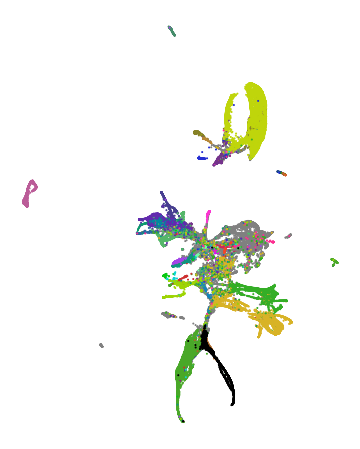

In [17]:
plt.figure(figsize=(8,8))
scatter = plt.scatter(*embd_during[special_order].T,
                      c=labels[special_order],
                      s=1.0,
                      alpha=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")

plt.savefig(os.path.join(fig_path, f"c_elegans_during_seed_{seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)

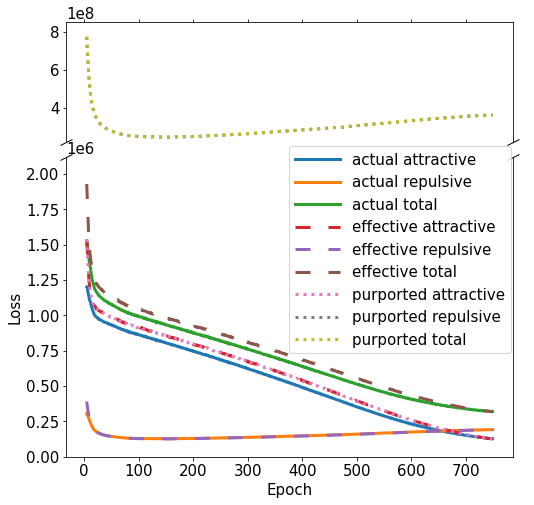

In [18]:
start=5
matplotlib.rcParams.update({'font.size': 15})
fig_losses_during = plot_all_losses(umapperns_during.aux_data,start=5)
fig_losses_during.savefig(os.path.join(fig_path, f"c_elegans_during_losses_{start}_seed_{seed}.png"),
                          bbox_inches = 'tight',
                          pad_inches = 0,
                          dpi=300)


## Variants with different high-dimensional similarities

### Shared kNN graph as high-dimensional similarities

In [19]:
try:
    with open(os.path.join(dir_path, f"umapperns_kNN_seed_{seed}.pkl"), "rb") as file:
        umapperns_kNN = pickle.load(file)
        embd_kNN = umapperns_kNN.embedding_
except FileNotFoundError:
    assert "umapperns_after" in locals()
    shared_kNN = umapperns_after.graph_.copy()
    shared_kNN.data = np.ones_like(shared_kNN.data)
    umapperns_kNN = umapns.UMAP(metric="cosine",
                                graph=shared_kNN,
                                n_neighbors=30,
                                n_epochs=750,
                                random_state=seed,
                                verbose=True)
    embd_kNN = umapperns_kNN.fit_transform(pca100)
    with open(os.path.join(dir_path, f"umapperns_kNN_seed_{seed}.pkl"), "wb") as file:
        pickle.dump(umapperns_kNN, file, pickle.HIGHEST_PROTOCOL)

UMAP(angular_rp_forest=True, dens_frac=0.0, dens_lambda=0.0,
     graph_=<86024x86024 sparse matrix of type '<class 'numpy.float32'>'
	with 3958760 stored elements in Compressed Sparse Row format>,
     metric='cosine', n_epochs=750, n_neighbors=30, random_state=0,
     verbose=True)
Construct fuzzy simplicial set
Wed Apr 21 16:37:51 2021 Construct embedding
	completed  0  /  750 epochs
	completed  75  /  750 epochs
	completed  150  /  750 epochs
	completed  225  /  750 epochs
	completed  300  /  750 epochs
	completed  375  /  750 epochs
	completed  450  /  750 epochs
	completed  525  /  750 epochs
	completed  600  /  750 epochs
	completed  675  /  750 epochs
Wed Apr 21 17:18:59 2021 Finished embedding


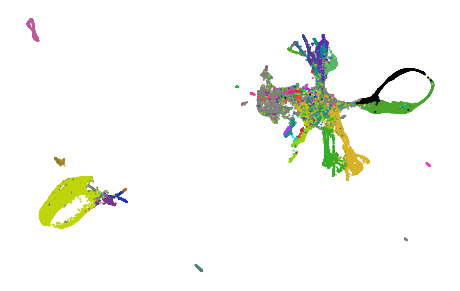

In [20]:
plt.figure(figsize=(8,8))
scatter = plt.scatter(embd_kNN[special_order][:,1],
                      embd_kNN[special_order][:, 0],
                      c=labels[special_order],
                      s=1.0,
                      alpha=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")

plt.savefig(os.path.join(fig_path, f"c_elegans_kNN_seed_{seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)

### Random permutation of positive high-dimensional similarities

In [21]:
try:
    with open(os.path.join(dir_path, f"umapperns_perm_seed_{seed}.pkl"), "rb") as file:
        umapperns_perm = pickle.load(file)
        embd_perm = umapperns_perm.embedding_
except FileNotFoundError:
    assert "umapperns_after" in locals()
    perm_graph = umapperns_after.graph_.copy()
    np.random.seed(seed)
    np.random.shuffle(perm_graph.data)
    umapperns_perm = umapns.UMAP(metric="cosine",
                                 graph=perm_graph,
                                 n_neighbors=30,
                                 n_epochs=750,
                                 random_state=seed,
                                 verbose=True)
    embd_perm = umapperns_perm.fit_transform(pca100)
    with open(os.path.join(dir_path, f"umapperns_perm_seed_{seed}.pkl"), "wb") as file:
        pickle.dump(umapperns_perm, file, pickle.HIGHEST_PROTOCOL)


UMAP(angular_rp_forest=True, dens_frac=0.0, dens_lambda=0.0,
     graph_=<86024x86024 sparse matrix of type '<class 'numpy.float32'>'
	with 3958760 stored elements in Compressed Sparse Row format>,
     metric='cosine', n_epochs=750, n_neighbors=30, random_state=0,
     verbose=True)
Construct fuzzy simplicial set
Wed Apr 21 17:19:04 2021 Construct embedding
	completed  0  /  750 epochs
	completed  75  /  750 epochs
	completed  150  /  750 epochs
	completed  225  /  750 epochs
	completed  300  /  750 epochs
	completed  375  /  750 epochs
	completed  450  /  750 epochs
	completed  525  /  750 epochs
	completed  600  /  750 epochs
	completed  675  /  750 epochs
Wed Apr 21 17:33:09 2021 Finished embedding


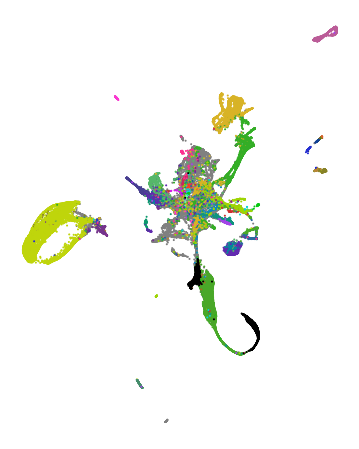

In [22]:
plt.figure(figsize=(8,8))
scatter = plt.scatter(*embd_perm[special_order].T,
                      c=labels[special_order],
                      s=1.0,
                      alpha=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")
plt.savefig(os.path.join(fig_path, f"c_elegans_perm_seed_{seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)


### Uniformly random positive high-dimensional similarities

In [23]:
try:
    with open(os.path.join(dir_path, f"umapperns_uni_seed_{seed}.pkl"), "rb") as file:
        umapperns_uni = pickle.load(file)
        embd_uni = umapperns_uni.embedding_
except FileNotFoundError:
    assert "umapperns_after" in locals()
    uni_graph = umapperns_after.graph_.copy()
    np.random.seed(seed)
    uni_graph.data = np.random.uniform(0, 1, size=uni_graph.data.shape)
    umapperns_uni = umapns.UMAP(metric="cosine",
                                graph=uni_graph,
                                n_neighbors=30,
                                n_epochs=750,
                                random_state=seed,
                                verbose=True)
    embd_uni = umapperns_uni.fit_transform(pca100)
    with open(os.path.join(dir_path, f"umapperns_uni_seed_{seed}.pkl"), "wb") as file:
        pickle.dump(umapperns_uni, file, pickle.HIGHEST_PROTOCOL)


UMAP(angular_rp_forest=True, dens_frac=0.0, dens_lambda=0.0,
     graph_=<86024x86024 sparse matrix of type '<class 'numpy.float64'>'
	with 3958760 stored elements in Compressed Sparse Row format>,
     metric='cosine', n_epochs=750, n_neighbors=30, random_state=0,
     verbose=True)
Construct fuzzy simplicial set
Wed Apr 21 17:33:14 2021 Construct embedding
	completed  0  /  750 epochs
	completed  75  /  750 epochs
	completed  150  /  750 epochs
	completed  225  /  750 epochs
	completed  300  /  750 epochs
	completed  375  /  750 epochs
	completed  450  /  750 epochs
	completed  525  /  750 epochs
	completed  600  /  750 epochs
	completed  675  /  750 epochs
Wed Apr 21 17:57:22 2021 Finished embedding


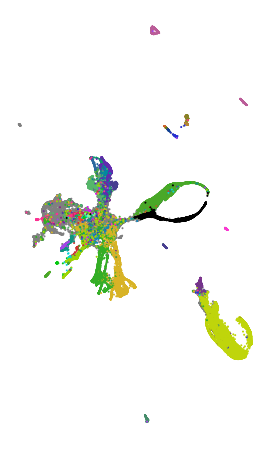

In [24]:
plt.figure(figsize=(8,8))
scatter = plt.scatter(-embd_uni[special_order][:, 0],
                      -embd_uni[special_order][:,1],
                      c=labels[special_order],
                      s=1.0,
                      alpha=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")
plt.savefig(os.path.join(fig_path, f"c_elegans_uni_seed_{seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)


### Inverted positive high-dimensional similarities

In [25]:
try:
    with open(os.path.join(dir_path, f"umapperns_inv_seed_{seed}.pkl"), "rb") as file:
        umapperns_inv = pickle.load(file)
        embd_inv = umapperns_inv.embedding_
except FileNotFoundError:
    assert "umapperns_after" in locals()
    inv_graph = umapperns_after.graph_.copy()
    inv_graph.data[inv_graph.data < inv_graph.data.max() / float(750)] = 0
    inv_graph.eliminate_zeros()
    inv_graph.data = inv_graph.data.min() / inv_graph.data
    umapperns_inv = umapns.UMAP(metric="cosine",
                                graph=inv_graph,
                                n_neighbors=30,
                                n_epochs=750,
                                random_state=seed,
                                verbose=True)
    embd_inv = umapperns_inv.fit_transform(pca100)
    with open(os.path.join(dir_path, f"umapperns_inv_seed_{seed}.pkl"), "wb") as file:
        pickle.dump(umapperns_inv, file, pickle.HIGHEST_PROTOCOL)


UMAP(angular_rp_forest=True, dens_frac=0.0, dens_lambda=0.0,
     graph_=<86024x86024 sparse matrix of type '<class 'numpy.float32'>'
	with 3954214 stored elements in Compressed Sparse Row format>,
     metric='cosine', n_epochs=750, n_neighbors=30, random_state=0,
     verbose=True)
Construct fuzzy simplicial set
Wed Apr 21 17:57:27 2021 Construct embedding
	completed  0  /  750 epochs
	completed  75  /  750 epochs
	completed  150  /  750 epochs
	completed  225  /  750 epochs
	completed  300  /  750 epochs
	completed  375  /  750 epochs
	completed  450  /  750 epochs
	completed  525  /  750 epochs
	completed  600  /  750 epochs
	completed  675  /  750 epochs
Wed Apr 21 18:04:04 2021 Finished embedding


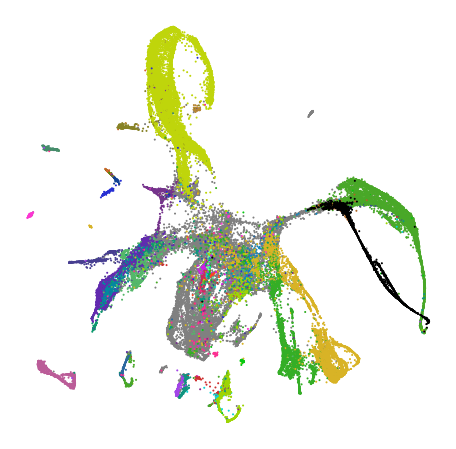

In [26]:
plt.figure(figsize=(8,8))
scatter = plt.scatter(-embd_inv[special_order][:, 1],
                      embd_inv[special_order][:, 0],
                      c=labels[special_order],
                      s=1.0,
                      alpha=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")

# dummy black dot for legend with only one entry
black_dot = mlines.Line2D([], [], color='black', marker='.', linestyle="none",
                          markersize=15, label=" ".join(special_cell_type.split("_")))
#plt.legend(handles=[black_dot], prop={'size': 20}, loc="lower right")
plt.savefig(os.path.join(fig_path, f"c_elegans_inv_seed_{seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)

## Variants with pushing the tail of a negative sample

### Normal setting

In [28]:
try:
    with open(os.path.join(dir_path, f"umapperns_push_tail_seed_{seed}.pkl"), "rb") as file:
        umapperns_push_tail = pickle.load(file)
        embd_push_tail = umapperns_push_tail.embedding_
except FileNotFoundError:
    umapperns_push_tail = umapns.UMAP(metric="cosine",
                                      n_neighbors=30,
                                      n_epochs=750,
                                      random_state=seed,
                                      verbose=True,
                                      push_tail=True)
    embd_push_tail = umapperns_push_tail.fit_transform(pca100)
    with open(os.path.join(dir_path, f"umapperns_push_tail_seed_{seed}.pkl"), "wb") as file:
        pickle.dump(umapperns_push_tail, file, pickle.HIGHEST_PROTOCOL)


UMAP(angular_rp_forest=True, dens_frac=0.0, dens_lambda=0.0, metric='cosine',
     n_epochs=750, n_neighbors=30, push_tail=True, random_state=0,
     verbose=True)
Construct fuzzy simplicial set
Wed Apr 21 20:55:31 2021 Finding Nearest Neighbors
Wed Apr 21 20:55:31 2021 Building RP forest with 20 trees
Wed Apr 21 20:55:32 2021 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Wed Apr 21 20:55:45 2021 Finished Nearest Neighbor Search
Wed Apr 21 20:55:47 2021 Construct embedding
	completed  0  /  750 epochs
	completed  75  /  750 epochs
	completed  150  /  750 epochs
	completed  225  /  750 epochs
	completed  300  /  750 epochs
	completed  375  /  750 epochs
	completed  450  /  750 epochs
	completed  525  /  750 epochs
	completed  600  /  750 epochs
	completed  675  /  750 epochs
Wed Apr 21 21:09:54 2021 Finished embedding
Wed Apr 21 21:09:58 2021 Worst tree score: 0.71890403
Wed Apr 21 21:09:58 2021 Mean tree score: 0.734

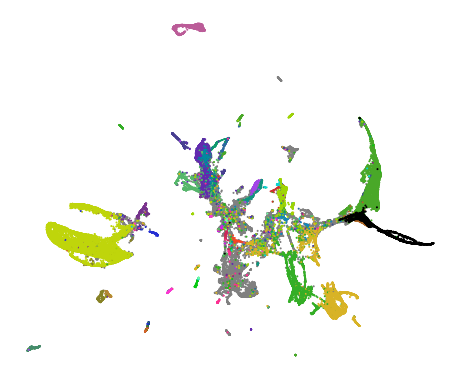

In [29]:
plt.figure(figsize=(8,8))
scatter = plt.scatter(-embd_push_tail[special_order][: ,1],
                      -embd_push_tail[special_order][:, 0],
                      c=labels[special_order],
                      s=1.0,
                      alpha=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")
plt.savefig(os.path.join(fig_path, f"c_elegans_push_tail_no_leg_seed_{seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)


### Shared kNN graph as high-dimensional similarities

In [30]:
try:
    with open(os.path.join(dir_path, f"umapperns_kNN_push_tail_seed_{seed}.pkl"), "rb") as file:
        umapperns_kNN_push_tail = pickle.load(file)
        embd_kNN_push_tail = umapperns_kNN_push_tail.embedding_
except FileNotFoundError:
    assert "umapperns_after" in locals()
    shared_kNN = umapperns_after.graph_.copy()
    shared_kNN.data = np.ones_like(shared_kNN.data)
    umapperns_kNN_push_tail = umapns.UMAP(metric="cosine",
                                          graph=shared_kNN,
                                          n_neighbors=30,
                                          n_epochs=750,
                                          push_tail=True,
                                          random_state=seed,
                                          verbose=True)
    embd_kNN_push_tail = umapperns_kNN_push_tail.fit_transform(pca100)
    with open(os.path.join(dir_path, f"umapperns_kNN_push_tail_seed_{seed}.pkl"), "wb") as file:
        pickle.dump(umapperns_kNN_push_tail, file, pickle.HIGHEST_PROTOCOL)

UMAP(angular_rp_forest=True, dens_frac=0.0, dens_lambda=0.0,
     graph_=<86024x86024 sparse matrix of type '<class 'numpy.float32'>'
	with 3958760 stored elements in Compressed Sparse Row format>,
     metric='cosine', n_epochs=750, n_neighbors=30, push_tail=True,
     random_state=0, verbose=True)
Construct fuzzy simplicial set
Wed Apr 21 21:10:05 2021 Construct embedding
	completed  0  /  750 epochs
	completed  75  /  750 epochs
	completed  150  /  750 epochs
	completed  225  /  750 epochs
	completed  300  /  750 epochs
	completed  375  /  750 epochs
	completed  450  /  750 epochs
	completed  525  /  750 epochs
	completed  600  /  750 epochs
	completed  675  /  750 epochs
Wed Apr 21 21:52:46 2021 Finished embedding


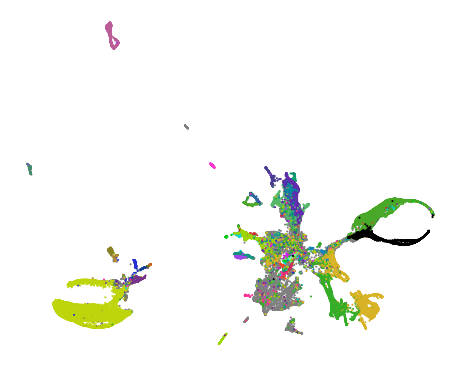

In [31]:
plt.figure(figsize=(8,8))
scatter = plt.scatter(embd_kNN_push_tail[special_order][:, 1],
                      embd_kNN_push_tail[special_order][:, 0],
                      c=labels[special_order],
                      s=1.0,
                      alpha=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")
plt.savefig(os.path.join(fig_path, f"c_elegans_kNN_push_tail_no_leg_seed_{seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)

### Random permutation of positive high-dimensional similarities

In [32]:
try:
    with open(os.path.join(dir_path, f"umapperns_perm_push_tail_seed_{seed}.pkl"), "rb") as file:
        umapperns_perm_push_tail = pickle.load(file)
        embd_perm_push_tail = umapperns_perm_push_tail.embedding_
except FileNotFoundError:
    assert "umapperns_after" in locals()
    perm_graph = umapperns_after.graph_.copy()
    np.random.seed(seed)
    np.random.shuffle(perm_graph.data)
    umapperns_perm_push_tail = umapns.UMAP(metric="cosine",
                                           graph=perm_graph,
                                           n_neighbors=30,
                                           n_epochs=750,
                                           push_tail=True,
                                           random_state=seed,
                                           verbose=True)
    embd_perm_push_tail = umapperns_perm_push_tail.fit_transform(pca100)
    with open(os.path.join(dir_path, f"umapperns_perm_push_tail_seed_{seed}.pkl"), "wb") as file:
        pickle.dump(umapperns_perm_push_tail, file, pickle.HIGHEST_PROTOCOL)

UMAP(angular_rp_forest=True, dens_frac=0.0, dens_lambda=0.0,
     graph_=<86024x86024 sparse matrix of type '<class 'numpy.float32'>'
	with 3958760 stored elements in Compressed Sparse Row format>,
     metric='cosine', n_epochs=750, n_neighbors=30, push_tail=True,
     random_state=0, verbose=True)
Construct fuzzy simplicial set
Wed Apr 21 21:52:51 2021 Construct embedding
	completed  0  /  750 epochs
	completed  75  /  750 epochs
	completed  150  /  750 epochs
	completed  225  /  750 epochs
	completed  300  /  750 epochs
	completed  375  /  750 epochs
	completed  450  /  750 epochs
	completed  525  /  750 epochs
	completed  600  /  750 epochs
	completed  675  /  750 epochs
Wed Apr 21 22:07:07 2021 Finished embedding


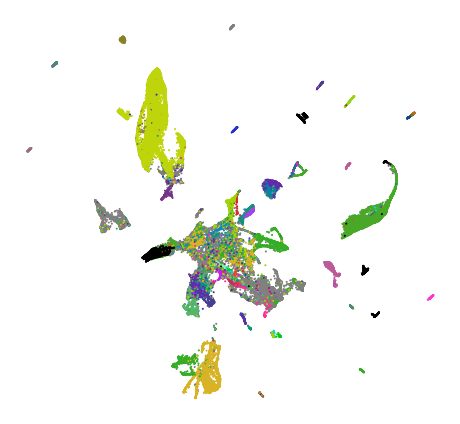

In [33]:
plt.figure(figsize=(8,8))
scatter = plt.scatter(embd_perm_push_tail[special_order][:, 0],
                      -embd_perm_push_tail[special_order][:, 1],
                      c=labels[special_order],
                      s=1.0,
                      alpha=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")
plt.savefig(os.path.join(fig_path, f"c_elegans_perm_push_tail_no_leg_seed_{seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)

### Uniformly random positive high-dimensional similarities

In [34]:
try:
    with open(os.path.join(dir_path, f"umapperns_uni_push_tail_seed_{seed}.pkl"), "rb") as file:
        umapperns_uni_push_tail = pickle.load(file)
        embd_uni_push_tail = umapperns_uni_push_tail.embedding_
except FileNotFoundError:
    assert "umapperns_after" in locals()
    uni_graph = umapperns_after.graph_.copy()
    np.random.seed(seed)
    uni_graph.data = np.random.uniform(0, 1, size=uni_graph.data.shape)
    umapperns_uni_push_tail = umapns.UMAP(metric="cosine",
                                          graph=uni_graph,
                                          n_neighbors=30,
                                          n_epochs=750,
                                          push_tail=True,
                                          random_state=seed,
                                          verbose=True)
    embd_uni_push_tail = umapperns_uni_push_tail.fit_transform(pca100)
    with open(os.path.join(dir_path, f"umapperns_uni_push_tail_seed_{seed}.pkl"), "wb") as file:
        pickle.dump(umapperns_uni_push_tail, file, pickle.HIGHEST_PROTOCOL)

UMAP(angular_rp_forest=True, dens_frac=0.0, dens_lambda=0.0,
     graph_=<86024x86024 sparse matrix of type '<class 'numpy.float64'>'
	with 3958760 stored elements in Compressed Sparse Row format>,
     metric='cosine', n_epochs=750, n_neighbors=30, push_tail=True,
     random_state=0, verbose=True)
Construct fuzzy simplicial set
Wed Apr 21 22:07:12 2021 Construct embedding
	completed  0  /  750 epochs
	completed  75  /  750 epochs
	completed  150  /  750 epochs
	completed  225  /  750 epochs
	completed  300  /  750 epochs
	completed  375  /  750 epochs
	completed  450  /  750 epochs
	completed  525  /  750 epochs
	completed  600  /  750 epochs
	completed  675  /  750 epochs
Wed Apr 21 22:31:56 2021 Finished embedding


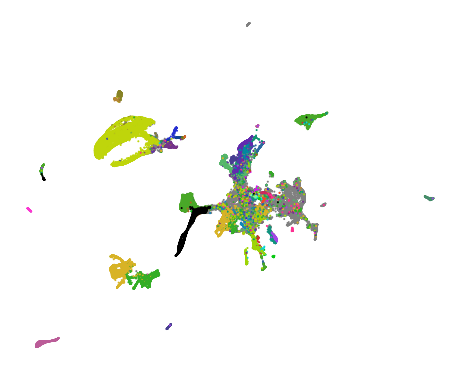

In [35]:
# labels 5, 14,21,23,28 have crips shape, but not in PCA
plt.figure(figsize=(8,8))
scatter = plt.scatter(embd_uni_push_tail[special_order][:, 0],
                      -embd_uni_push_tail[special_order][:, 1],
                      c=labels[special_order],
                      s=1.0,
                      alpha=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")
plt.savefig(os.path.join(fig_path, f"c_elegans_uni_push_tail_no_leg_seed_{seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)

### Inverted positive high-dimensional similarities

In [36]:
try:
    with open(os.path.join(dir_path, f"umapperns_inv_push_tail_seed_{seed}.pkl"), "rb") as file:
        umapperns_inv_push_tail = pickle.load(file)
        embd_inv_push_tail = umapperns_inv_push_tail.embedding_
except FileNotFoundError:
    assert "umapperns_after" in locals()
    inv_graph = umapperns_after.graph_.copy()
    inv_graph.data[inv_graph.data < inv_graph.data.max() / float(750)] = 0
    inv_graph.eliminate_zeros()
    inv_graph.data = inv_graph.data.min() / inv_graph.data
    umapperns_inv_push_tail = umapns.UMAP(metric="cosine",
                                          graph=inv_graph,
                                          n_neighbors=30,
                                          n_epochs=750,
                                          push_tail=True,
                                          random_state=seed,
                                          verbose=True)
    embd_inv_push_tail = umapperns_inv_push_tail.fit_transform(pca100)
    with open(os.path.join(dir_path, f"umapperns_inv_push_tail_seed_{seed}.pkl"), "wb") as file:
        pickle.dump(umapperns_inv_push_tail, file, pickle.HIGHEST_PROTOCOL)

UMAP(angular_rp_forest=True, dens_frac=0.0, dens_lambda=0.0,
     graph_=<86024x86024 sparse matrix of type '<class 'numpy.float32'>'
	with 3954214 stored elements in Compressed Sparse Row format>,
     metric='cosine', n_epochs=750, n_neighbors=30, push_tail=True,
     random_state=0, verbose=True)
Construct fuzzy simplicial set
Wed Apr 21 22:32:00 2021 Construct embedding
	completed  0  /  750 epochs
	completed  75  /  750 epochs
	completed  150  /  750 epochs
	completed  225  /  750 epochs
	completed  300  /  750 epochs
	completed  375  /  750 epochs
	completed  450  /  750 epochs
	completed  525  /  750 epochs
	completed  600  /  750 epochs
	completed  675  /  750 epochs
Wed Apr 21 22:38:33 2021 Finished embedding


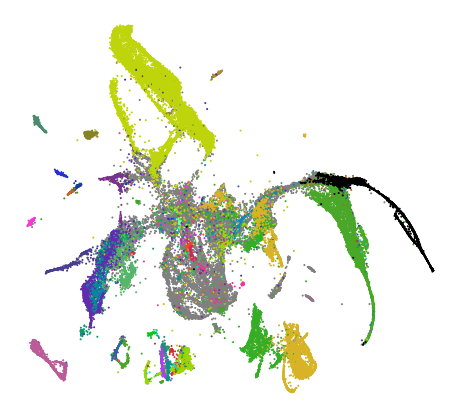

In [37]:
plt.figure(figsize=(8,8))
scatter = plt.scatter(-embd_inv_push_tail[special_order][:, 1],
                      embd_inv_push_tail[special_order][:, 0],
                      c=labels[special_order],
                      s=1.0,
                      alpha=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")
plt.savefig(os.path.join(fig_path, f"c_elegans_inv_push_tail_no_leg_seed_{seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)